# Derive hypsometry using IceSAT-2 methods for a local reservoir

This script computes the hypsometric curve extracted from paired icesat2 and water surface area estimates based on a shapefile geometry for a given arbitrary reservoir.
Both Icesat ATL08 or ATL03 can be used to derive the hypsometry. ATL08 is further processed than ATL03. For the differences, we refer to https://icesat-2.gsfc.nasa.gov/science/data-products.

Important to understand is that a part of this processing, i.e. the retrieval of water surface areas at or around dates of overpass of ICESat-2, is done on Google Earth Engine. The steps are roughly:

1. Define a polygon of interest, roughly encapsulating the reservoir of interest
2. Retrieve ICESat-2 overpass data (for ATL03 or ATL08) for the reservoir of interest
3. Send the ICESat-2 data to Google Earth Engine (GEE)
4. @GEE, retrieve surface water area for the polygon of interest for the overpass dates of ICESat-2
5. ...

Let's start with loading all packages and libraries we may need.

In [11]:
import osgeo
import bathypy

from shapely.geometry import Point, Polygon, MultiPolygon

from shapely import unary_union

from tqdm import tqdm
import pandas as pd
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import matplotlib
import ee
import geemap
import datetime

import json

ee.Initialize()

### Get a polygon of interest
Below a polygon if interest is loaded in memory and converted into a Earth Engine FeatureCollection

<Axes: >

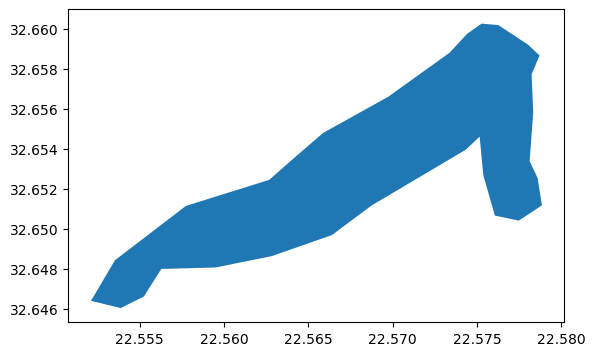

In [12]:
reservoir_poly = gpd.read_file(r'.\examples\datasets\wadiMansour_reservoir.geojson')
reservoir_poly = gpd.GeoDataFrame(data={"fid": [0], "geometry": reservoir_poly.geometry}, crs=4326)
reservoir = ee.FeatureCollection(json.loads(reservoir_poly.to_json())).first()
reservoir_poly.plot()

### Retrieve ICESat-2 overpass data
We have an automated approach to retrieve ICESat-2 data, that exactly overpasses the reservoir, with some buffer. The data is stored in a regular pandas DataFrame. Below we call this functionality for our reservoir of choice. We convert the pandas DataFrame into a geodataframe for convenience of plotting. Please note that this will take some time to process as it requires several calls to the IceSAT-2 API.


In [13]:
#### Extract ICESAT2_overpasses
# Get Icesat2 data for feature
df = bathypy.icesat2.get_icesat2_data(
    aoi=reservoir_poly,
    icesat2_product='atl08'
)

df_gpd = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
df_gpd['date'] = [datetime.datetime.fromtimestamp(s/1000).strftime("%Y-%m-%d") for s in df_gpd['system:time_start']]
df_gpd['lon'] = df_gpd['longitude']
df_gpd['lat'] = df_gpd['latitude']

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

### Plot the ICESat-2 tracks per date on a simple axes

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.gca()
reservoir_poly.boundary.plot(ax=ax, color='blue', linewidth=2)

# Coloring the points associated with each date
unique_dates = df_gpd['date'].unique()  # Get unique dates from the DataFrame

# Assign a color to each unique date
color_map = plt.cm.get_cmap('tab10', len(unique_dates))

# Iterate over unique dates and plot points with associated color
for i, date in enumerate(unique_dates):
    df_date = df_gpd[df_gpd['date'] == date]  # Filter DataFrame for a specific date
    ax.scatter(df_date['lon'], df_date['lat'], color=color_map(i), label=date)

# Add a legend to the plot
ax.legend()



### Move the ICESat-2 tracks to Earth Engine
The ICESat-2 tracks are now locally available in-memory. Now we need to retrieve water surface area estimates for the reservoir in the same (or nearly the same) overpass dates. For this, we need to move the ICESat-2 track data to Earth Engine. Below we do this by converting the tracks into a Earth Engine FeatureCollection


In [ ]:
featureCollection_icesat2 = ee.FeatureCollection(
    json.loads(
        df_gpd.to_json()
    )
)

### Retrieve satellite images that are within the time span of the retrieved ICESat-2 overpasses
This is done by calling functionality within GEE that concatenates Landsat-8 and Sentinel-2 image collections. You can therefore expect images from both satellite missions in the results. The scale is set to 100 meters.

In [ ]:
clean_images: ee.ImageCollection = bathypy.storage.get_waterbody_images(
    waterbody=reservoir.geometry(),
    start=(datetime.datetime.fromtimestamp(df['system:time_start'].min()/1000)).strftime("%Y-%m-%d"),
    stop=(datetime.datetime.fromtimestamp(df['system:time_start'].max()/1000)).strftime("%Y-%m-%d"),
    scale=100,
    mostly_clean=True
)

### Check out a random image from the collection
You will see that one image over the area of interest is collected.

In [ ]:
Map = geemap.Map()
# select bands to plot as RGB and their scale
vis = {'bands': ['red', 'green', 'blue'], 'min': 0, 'max': 0.3, 'gamma': 1.4}
Map.addLayer(clean_images.first(), vis, "first image")
waterbody = ee.Feature(reservoir)
Map.addLayer(waterbody, {}, "reservoir")
Map


### Retrieving the image pairs
The clean images are now filtered for images that can be paired with the ICESat-2 tracks, and for each pair, a hypsometric point is established. Below we use a maximum window in time around each ICESat-2 track of 10 days. We also do not subsample the ICESat-2 tracks. If you consider the code to be slow, you may alter `subsample_is2_frac` to a lower value. E.g. `subsample_is2_frac=0.1` means only 10% of the ICESat-2 points are used. This part of the notebook may take significant time as many satellite data have to be number-crunched.

In [ ]:
df_is2, hypso_points = bathypy.storage.get_watermasks_icesat2(
    clean_images=clean_images,
    icesatdataframe=df_gpd,
    waterbody=ee.Feature(reservoir),
    max_time_window=10,
    subsample_is2_frac=0.1
)

### plot the hypsometric points in a simple axes
Below we have a first look at the results.

In [ ]:
plt.figure()
plt.scatter(
    hypso_points.water_area,
    hypso_points.h,
    c='k'
)
plt.xlabel("Surface area [m2]")
plt.ylabel("Water level [m + WGS84] ")
plt.grid(linestyle="--")

### retrieve a hyspometric relationship fitted through the points
We use the static hypsometry methods to derive a relationship. Here we also derive a fit with the function

$A(h) = a\left(h-h_0\right)^b$

In [ ]:
from bathypy.static_hypso import Hypsometry
hypso = Hypsometry(
    water_level=hypso_points.h.values,
    area=hypso_points.water_area.values
)


In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
hypso.plot(ax=ax1)
hypso.plot(x="water_level", y="volume", ax=ax2)
hypso.plot(x="area", y="volume", ax=ax3)


### Store hypsometric points to a file
We can store the hypsometry relationship to a file for later use.

In [ ]:
hypso.to_file("dynamic_hypso.csv")